<a href="https://colab.research.google.com/github/oduolaidrisA/Rayleigh_Quotient_PINNs/blob/main/rqpinn_harmonic_oscillator_well_with_attention_final_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider the problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) = \frac{1}{2}m\omega^2x^2
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 10$, $\hbar = 1, m = 1 $ and $\omega = 1$

In [1]:
pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=b92a57c9ff2adea64417ad66a7b2f4943da5fcc872ad020934f5561dfca7c189
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [47]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
import pandas as pd  #for the moving average
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

from pyDOE import lhs #latin hypercube sampling

cuda
Tesla T4


In [48]:
#First and second derivatives from Automatic Differentiation
def dfx(f,x):
  u_x = []; u_xx = []
  for i in range(f.shape[1]):
    u_x.append(grad(f[:,i], x, grad_outputs=torch.ones_like(f[:,i]), create_graph=True)[0])
    u_xx.append(grad(u_x[i].view(-1), x, grad_outputs=torch.ones_like(f[:,i]), create_graph=True)[0])
  u_x = torch.cat(u_x, dim=1); u_xx = torch.cat(u_xx, dim=1)
  return u_x, u_xx

In [76]:
#Defining the hyperparameters
class config:
  def __init__(self):
    self.t0 = -10
    self.tf = 10
    self.xbc = 0
    self.eig_num = 3
    self.col_pts = 200
    self.layers = [1,100,100,self.eig_num]
    self.epochs = 20000

cfg = config()

In [77]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,cfg):
  N1 = nn(t)
  f = ((1-torch.exp(-(t - cfg.t0)))*(1-torch.exp(t - cfg.tf))).view(-1,1)
  psi_hat = cfg.xbc + f*N1 #Broadcasting is done here
  return psi_hat

In [78]:
def hamEqs_Loss(t,psi, psi_xx, v): #Defines the PDE loss
  # Hamiltonian applied to psi
    hamEqs = -0.5 * psi_xx + v * psi
    numerator = torch.trapz(psi * hamEqs, t, dim=0)
    denominator = torch.trapz(psi ** 2, t, dim=0)
    E = numerator / denominator
    # Residual (Schrödinger equation)
    res = 0.5*psi_xx + (E - v) * psi
    #L = res/(torch.abs(psi) + 1e-3)
    return res, E

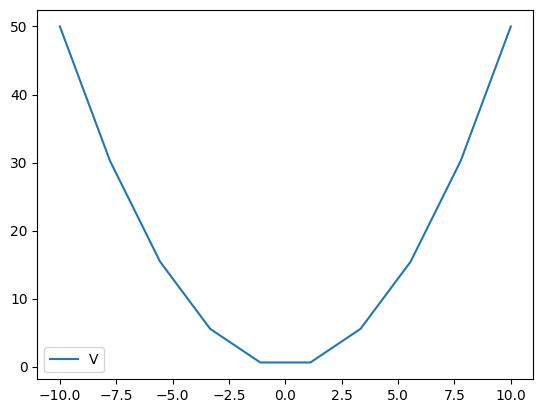

In [79]:
#Defining the potential well
def V(x):
    y = 0.5*x**2
    return y
x = torch.linspace(cfg.t0,cfg.tf,10).view(-1,1)
pot = V(x)
#scaled_pot = V_norm(x)

plt.plot(x,pot, label='V')
plt.legend()
plt.show()

In [80]:
#Defining the Frobenius norm
def frobenius_norm(G):
    I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
    loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
    return loss

#Defining the monotonicity_penalty, this is to ensure that the eigenpairs are learned monotonically
def monotonicity_penalty(E, margin = 0.0):
    diffs = E[:-1] - E[1:] + margin
    penalty = torch.relu(diffs).sum()
    return penalty

#Defining the cosine matrix
def cosine_matrix(psi,x):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  psi_normalized = psi / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = torch.trapz(psi_prod, x, dim=0)
  return cos_matrix

#Norm loss to ensure the wavefunctions are properly scaled
def norm_loss(psi,x,cfg):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  scale_term = (cfg.tf - cfg.t0)*psi_norm/cfg.col_pts
  return torch.sum((1-scale_term).pow(2))

In [81]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,cfg):
    super(qNN,self).__init__()
    self.activation = torch.sin
    self.layers = cfg.layers

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)])

    for i in range(len(self.layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)
    #Initializing the weights
    #with torch.no_grad():
    #  for i in range(len(self.layers)-1):
    #    if i ==0:
    #      self.linears[i].weight.uniform_(-1/self.layers[i], 1/self.layers[i])
    #    else:
    #      self.linears[i].weight.uniform_(-np.sqrt(6/self.layers[i]), np.sqrt(6/self.layers[i] ))



  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      if i == 0:
        a = self.activation(30*z)
      else:
        a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [82]:
#Defining group equivariant RqPINN
class equiRqNN(torch.nn.Module):
  def __init__(self,cfg):
    super(equiRqNN,self).__init__()
    self.activation = torch.sin #The activation function
    self.layers = cfg.layers

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)])

    #Initializing the weights
    for i in range(len(self.layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      if i ==len(self.layers)-2:
        nn.init.zeros_(self.linears[i].bias.data) #Initializing the bias of the last layer to zeros
      else:
        nn.init.normal_(self.linears[i].bias.data)

  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x).float()
    a0 = torch.cat([x,-x], dim=0).view(2,-1,self.layers[0])
    #Implementing equivariance for l = 1
    z1 = self.linears[0](a0)
    a1 = self.activation(10.0*z1)

    #Implementing equivariance for 1 < l < L-1
    for i in range(1,len(self.linears)-1):
      z21 = self.linears[i](a1[0,:,:] - a1[1,:,:])
      z22 = self.linears[i](a1[1,:,:] - a1[0,:,:])
      z = torch.cat([z21,z22], dim = 0).view(2,-1,self.layers[i+1])
      a1 = self.activation(10.0*z)

    #Implementing equivariance for l = L
    out = self.linears[-1](a1[0,:,:] - a1[1,:,:])
    return out

### Pre-trainer

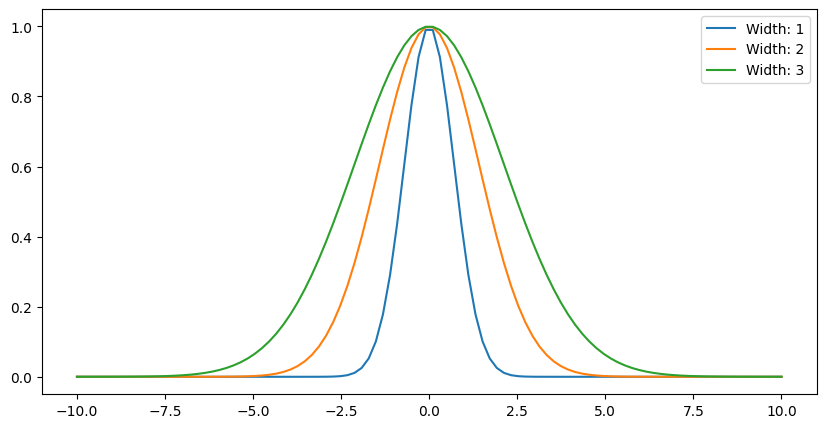

In [83]:
def fg(x, s):
  """Batch of Gaussians for different widths."""
  return torch.exp(-(x / s.unsqueeze(0)) ** 2)  # (n_points, n_functions)


x = torch.linspace(cfg.t0,cfg.tf,100).view(-1,1)
n_points = x.shape[0]; N_max = cfg.eig_num
pn = torch.arange(1,N_max+1) #Sequence from 1 to number of eigenvalues
n = pn -1 #Sequence from 0 to number of eigenvalues - 1
gaussian = fg(x, pn) #Gaussians with increasing width

#Plot of the gaussians with increased width
plt.figure(figsize=(10,5))
for i in range(len(pn)):
  plt.plot(x.view(-1), gaussian[:,i], label=f'Width: {pn[i].item()}')
plt.legend()
plt.show()


tensor([0.])
tensor([-0.6667,  0.6667])


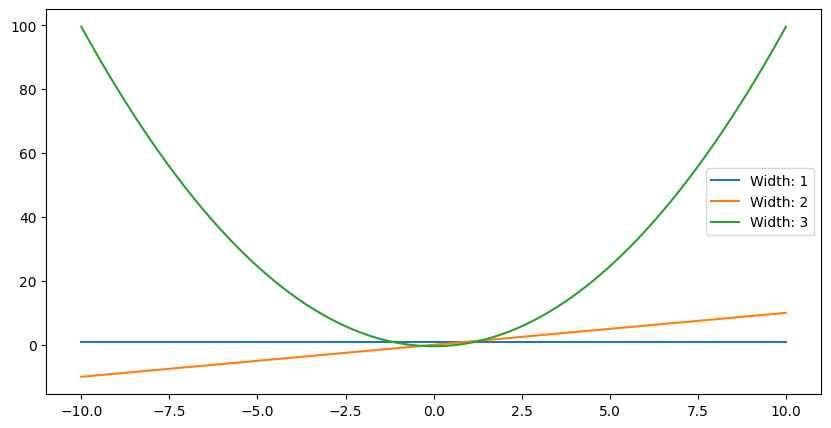

In [84]:
#The modulated polynomials
mfun = torch.ones(n_points, N_max)
for idx in range(N_max):
  deg = n[idx] #The degree of the polynomial
  if deg > 0:
    sp = (cfg.tf - cfg.t0)/pn[idx]
    roots = (torch.arange(1, deg+1) * sp + cfg.t0) * 0.2  # The roots
    print(roots)
    for pm in range(deg):
      mfun[:,idx] *= (x.view(-1) - roots[pm])

plt.figure(figsize=(10,5))
for i in range(len(pn)):
  plt.plot(x.view(-1), mfun[:,i], label=f'Width: {pn[i].item()}')
plt.legend()
plt.show()

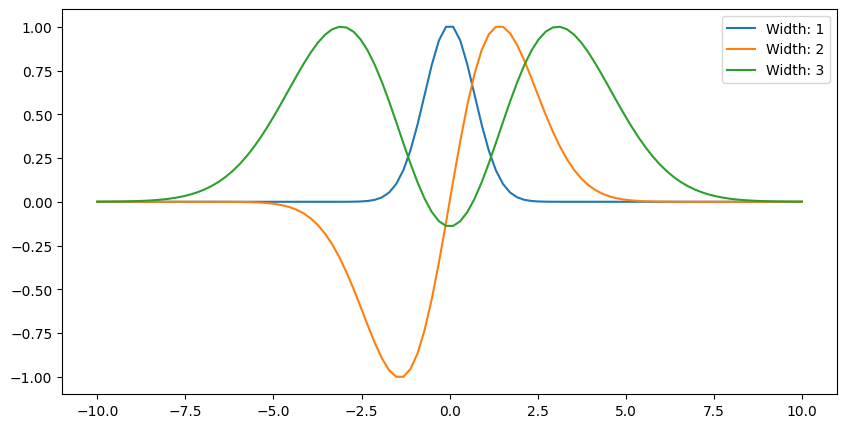

In [85]:
basis = gaussian*mfun

#Normalizing the basis
basis = basis/ basis.abs().max(dim=0, keepdim=True).values        #torch.norm(basis, dim = 0, keepdim = True)

plt.figure(figsize=(10,5))
for i in range(len(pn)):
  plt.plot(x.view(-1), basis[:,i], label=f'Width: {pn[i].item()}')
plt.legend()
plt.show()

In [86]:
#Putting all together
def gauss_modulated_basis(x, cfg):
  n_points = x.shape[0]; N_max = cfg.eig_num
  pn = torch.arange(1,N_max+1) #Sequence from 1 to number of eigenvalues
  n = pn -1 #Sequence from 0 to number of eigenvalues - 1
  gaussian = fg(x, pn) #Gaussians with increasing width

  mfun = torch.ones(n_points, N_max)
  for idx in range(N_max):
    deg = n[idx] #The degree of the polynomial
    if deg > 0:
      sp = (cfg.tf - cfg.t0)/pn[idx]
      roots = (torch.arange(1, deg+1) * sp + cfg.t0) * 0.2  # The roots
      for pm in range(deg):
        mfun[:,idx] *= (x.view(-1) - roots[pm])

  basis = gaussian*mfun

  #Normalizing the basis
  basis = basis/ basis.abs().max(dim=0, keepdim=True).values    #torch.norm(basis, dim = 0, keepdim = True)
  return basis

In [87]:
#Pretrainer step
def pretrainer_step(NN, t_rand, psi_gauss):
  psi = NN(t_rand)
  #psi_normal = psi/torch.norm(psi, dim = 0, keepdim = True)
  loss = F.mse_loss(psi, psi_gauss)
  return loss

### Learning Rate Finder

In [88]:
#We want to find the best lr for our defined model
model_lr = qNN(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

In [89]:
def common_train_step(NN,t_rand,t_sort,idx,vx, cfg):
    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,cfg) #The forward pass
    psi = psi.to(device)
    #psi_normal = psi/torch.norm(psi, dim = 0, keepdim = True)

    # Compute second derivatives
    psi_x, psi_xx = dfx(psi, t_rand)

    psi_sort = psi[idx,:].to(device); psi_xx_sort = psi_xx[idx,:].to(device)

    L,E = hamEqs_Loss(t_sort,psi_sort,psi_xx_sort,vx)
    Loss = torch.nn.MSELoss()
    #Getting the losses after each forward pass
    pde_loss = Loss(L,torch.zeros_like(L))  #The scaled pde_loss
    n_loss = norm_loss(psi_sort,t_sort,cfg)
    G = cosine_matrix(psi_sort, t_sort)
    cosine_loss = frobenius_norm(G)
    return pde_loss, n_loss, cosine_loss, E

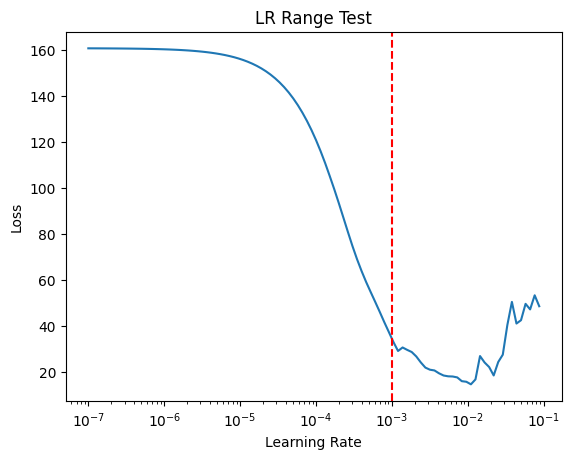

In [90]:
# Set up variables
x_lhs = torch.tensor(cfg.t0 + (cfg.tf - cfg.t0)*lhs(1,cfg.col_pts)).view(-1,1).float()
#x_lhs.requires_grad =True
losses = []
lrs = []

#Sorting and unsorting here
# Sort only the coordinates, without gradients
with torch.no_grad():
    t_squeezed = x_lhs.squeeze(-1)
    t_sort, idx = torch.sort(t_squeezed, dim=0)

x_lhs = x_lhs.to(device)
x_lhs.requires_grad = True
vx = V(t_sort.unsqueeze(1)).to(device)
t_sort = t_sort.to(device)

start_lr = 1e-7
end_lr = 0.1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss, n_loss, cosine_loss,En= common_train_step(model_lr,x_lhs, t_sort,idx,vx,cfg)
    monotone_loss =monotonicity_penalty(En, margin = 0.1)
    loss = pde_loss + n_loss+ cosine_loss + monotone_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.axvline(x=1e-3, color='red', linestyle='--')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

In [91]:
model = qNN(cfg)
model.to(device)
print(model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=5e-5, betas=betas)
#scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [92]:
def nn_train(NN,t,cfg):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_dic = {'pde_loss_hist': [], 'cos_loss_hist': [], 'norm_loss':[], 'total_loss_hist': []} #To store the losses
  #Sorting and unsorting here
  # Sort only the coordinates, without gradients
  t_sort, idx = torch.sort(t.squeeze(-1), dim=0)

  pn = torch.arange(1,cfg.eig_num+1) #Sequence from 1 to number of eigenvalues
  gaussian = fg(t, pn).to(device) #Gaussians with increasing width

  t_rand = t.to(device).requires_grad_(True).float()

  #Obtaining the Gauss Modulated basis for pre-training
  gm_basis = gauss_modulated_basis(t_sort.view(-1,1),cfg)
  gm_basis_lhs = gm_basis[torch.argsort(idx), :].to(device) #To unsort i.e make the index match that of x_lhs


  #Obtaining the potential
  vx = V(t_sort.unsqueeze(1)).to(device)

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(cfg.epochs + 1):
    optimizer.zero_grad()
    if iter < 3000:
      total_loss = pretrainer_step(NN, t_rand, gaussian)
      if iter % 1000 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
    else:
      criteria_loss,n_loss, cosine_loss,En = common_train_step(NN,t_rand,t_sort.to(device),idx,vx,cfg)
      monotone_loss = monotonicity_penalty(En, margin = 0.1)
      total_loss = criteria_loss + n_loss + cosine_loss + monotone_loss

      En_history.append(En.cpu().detach().numpy())

      loss_dic['pde_loss_hist'].append(criteria_loss.item())
      loss_dic['cos_loss_hist'].append(cosine_loss.item())
      loss_dic['norm_loss'].append(n_loss.item())
      if iter % 200 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1]}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
        print('pde_loss: ',criteria_loss.item())
        print('norm_loss: ',n_loss.item())
        print('cos_loss: ',cosine_loss.item())
        print('Monotone_loss: ', monotone_loss.item())


    #Backward propagation
    total_loss.backward()

    #Gradient Clipping
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm=10.0)

    #if iter % 100 == 0:
    #  for name, param in NN.named_parameters():
    #    if param.grad is not None:
    #      print(f'{name}: {param.grad.norm().item():.6f}')
    optimizer.step()
    #Scheduler
    #if iter > 15000:
    #  scheduler.step()

    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [93]:
x_lhs = torch.tensor(cfg.t0 + (cfg.tf - cfg.t0)*lhs(1,cfg.col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([200, 1])

In [94]:
Loss, eig_vals, qPINN = nn_train(model,x_lhs,cfg)

--------------------------------------------
Epoch: 0
--------------------------------------------
Total_loss:  0.5754305124282837
--------------------------------------------
Epoch: 1000
--------------------------------------------
Total_loss:  0.01868181861937046
--------------------------------------------
Epoch: 2000
--------------------------------------------
Total_loss:  0.005671555642038584
--------------------------------------------
Epoch: 3000
En: [1.9497951 1.2526512 1.517745 ]
--------------------------------------------
Total_loss:  20.981441497802734
pde_loss:  15.945378303527832
norm_loss:  2.1139349937438965
cos_loss:  2.1249840259552
Monotone_loss:  0.7971439361572266
--------------------------------------------
Epoch: 3200
En: [1.009696  1.1538869 1.3040937]
--------------------------------------------
Total_loss:  9.967899322509766
pde_loss:  5.941295146942139
norm_loss:  2.0722904205322266
cos_loss:  1.9543132781982422
Monotone_loss:  0.0
--------------------------

In [95]:
qPINN

{1: qNN(
   (linears): ModuleList(
     (0): Linear(in_features=1, out_features=100, bias=True)
     (1): Linear(in_features=100, out_features=100, bias=True)
     (2): Linear(in_features=100, out_features=3, bias=True)
   )
 )}

In [96]:
tTest = torch.linspace(cfg.t0,cfg.tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),cfg).data.numpy()

In [97]:
#Sorting the eigenfunctions
eigs = eig_vals[-1]
indices = np.argsort(eigs)
eigs_arranged = eigs[indices]

psi = psi[:,indices]

In [98]:
eigs

array([0.50996786, 1.5030822 , 2.5100088 ], dtype=float32)

In [32]:
checkpoint = {
    'model_state_dict': qPINN[1].state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dic': Loss,
    'eig_vals': eig_vals
}
torch.save(checkpoint, f'harmonic_oscillator_first_good_result.pth')

In [99]:
psi_new = torch.tensor(psi)
psi_norm = torch.sqrt(torch.trapz(psi_new**2, tTest, dim=0))  # (k,)
print(psi_norm)
psi_normalized = psi_new / psi_norm  # (n, k)
psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
print(psi_prod.shape)
cos_matrix = torch.trapz(psi_prod, torch.tensor(t_net).view(-1), dim=0)
cos_matrix.shape

tensor([9.9693, 9.9451, 9.9398], grad_fn=<SqrtBackward0>)
torch.Size([1200, 3, 3])


torch.Size([3, 3])

In [100]:
cos_matrix

tensor([[ 1.0000e+00,  5.9810e-04, -1.3893e-05],
        [ 5.9810e-04,  1.0000e+00, -3.4123e-04],
        [-1.3893e-05, -3.4123e-04,  1.0000e+00]], grad_fn=<DivBackward1>)

In [101]:
psi_norm = psi_new/ torch.norm(psi_new, dim = 0, keepdim = True)
cos_matrix = psi_norm.T @ psi_norm
cos_matrix

tensor([[ 1.0000e+00,  5.9808e-04, -1.3639e-05],
        [ 5.9808e-04,  1.0000e+00, -3.4122e-04],
        [-1.3639e-05, -3.4122e-04,  1.0000e+00]])

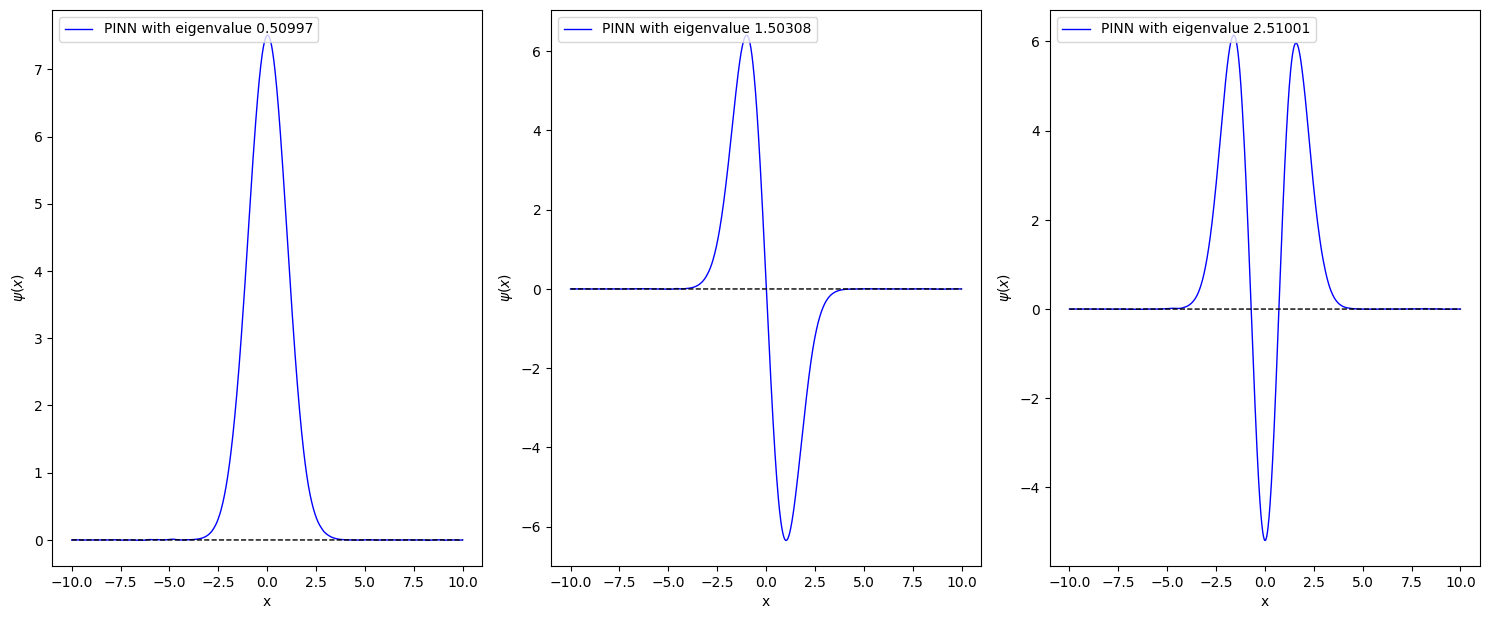

In [102]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eigs_arranged[:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi[:,index], color='blue', linewidth=1, label=f'PINN with eigenvalue {eigs_arranged[index]:.5f}')
    ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

### Comparison with Exact Solution

In [ ]:
def exact(n,x):
  return np.sqrt(2/np.pi)*np.sin(n*x)

y_exact = {j: exact(j,t_net) for j in range(1,eig_num+1)}

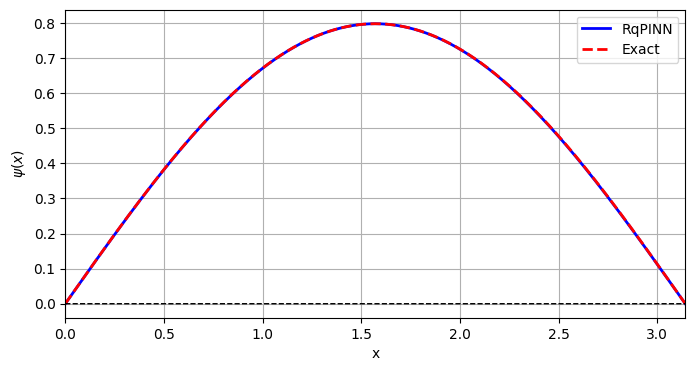

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, -np.sqrt(2/np.pi)*psi[:,0]/max(abs(psi[:, 0])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[1],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

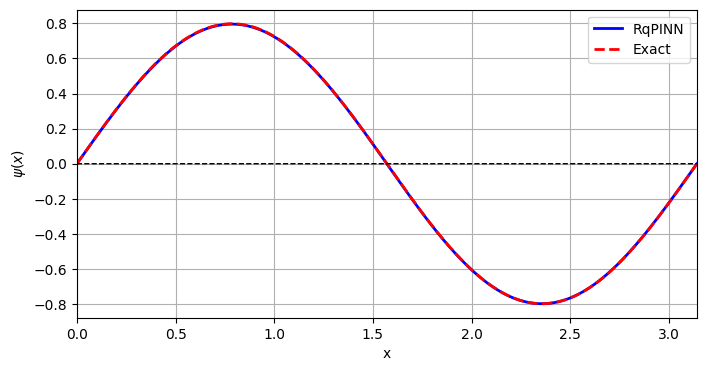

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, -np.sqrt(2/np.pi)*psi[:,1]/max(abs(psi[:, 1])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[2],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

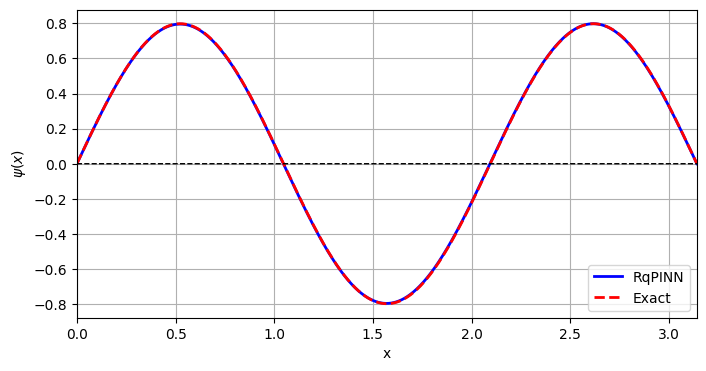

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, np.sqrt(2/np.pi)*psi[:,2]/max(abs(psi[:, 2])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[3],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='lower right')

plt.grid('on')
plt.show()

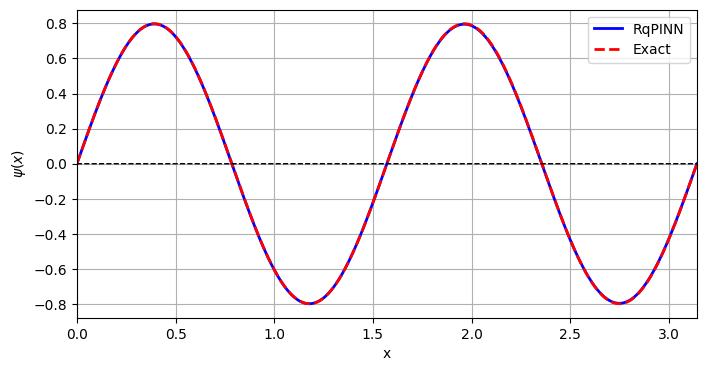

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, np.sqrt(2/np.pi)*psi[:,3]/max(abs(psi[:, 3])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[4],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

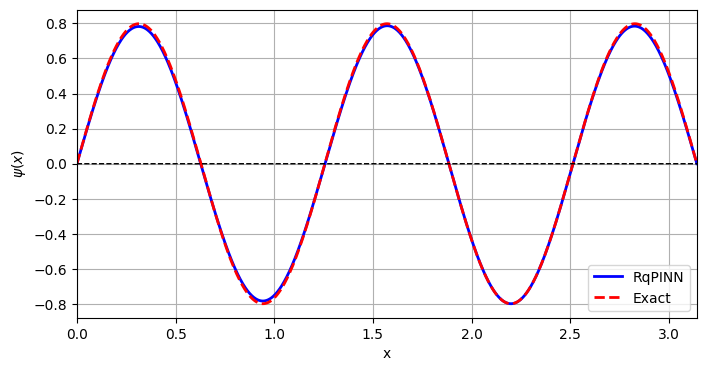

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, -np.sqrt(2/np.pi)*psi[:,4]/max(abs(psi[:, 4])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[5],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='lower right')

plt.grid('on')
plt.show()

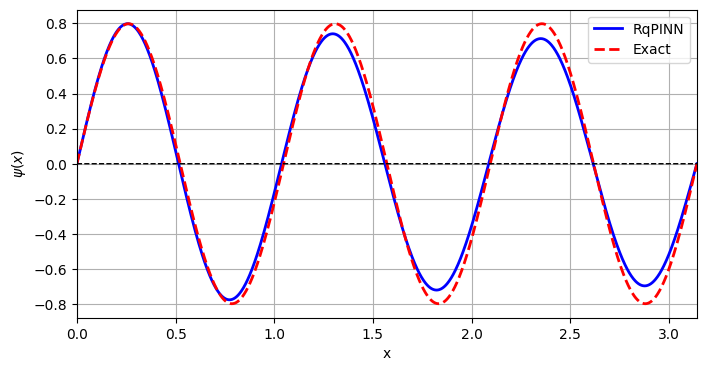

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, np.sqrt(2/np.pi)*psi[:,5]/max(abs(psi[:, 5])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[6],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

## Projecting the Output into an orthonormal basis

In [ ]:
#Adding a custom orthonormal projection layer
class qrlayer(torch.nn.Module):
    def forward(self, x):
        Q,_ = torch.linalg.qr(x)
        return Q

#Now adding the layer to the neural network architecture
class qNN_qr(torch.nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.base = qNN(layers)
        self.qr = qrlayer()

    def forward(self, x):
        out = self.base(x)
        out = self.qr(out/torch.norm(out, dim = 0, keepdim = True))
        return out

In [ ]:
model1 = qNN_qr(layers)
model1.to(device)
print(model1)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

qNN_qr(
  (base): qNN(
    (activation): sine()
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
  (qr): qrlayer()
)


In [ ]:
def nn_qr_train(NN,t0,tf,xbc,col_pts, epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  t_rand = t[torch.randperm(t.shape[0])].to(device).float() #Reshuffling the collocation points
  t_rand.requires_grad =True

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(epochs + 1):
    loss = 0.0

    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,t0,tf,xbc).to(device) #The forward pass

    L,En = hamEqs_Loss(t_rand,psi)
    En_history.append(En.cpu().detach().numpy())
    Loss = torch.nn.MSELoss()
    criteria_loss = eig_num*Loss(L,torch.zeros_like(L)) #The scaled pde_loss
    #Getting the loss after the forward pass
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())



    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print('--------------------------------------------')
      print('Total_loss: ',criteria_loss.cpu().detach().numpy())


    #Backward propagation
    optimizer.zero_grad()
    criteria_loss.backward()
    #Introducing Gradient clipping
    #max_norm =12.0
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm)
    optimizer.step()
    loss += criteria_loss.cpu().detach().numpy()

  #Storing the final eigenfunction and eigenvalue
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [ ]:
Loss, eig_vals, qPINN = nn_qr_train(model1,t0,tf,xbc,col_pts,epochs, x_lhs)